In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
from datetime import timedelta
import numpy as np

In [2]:
data = pd.read_csv("./fraud_order_classifier.csv")

In [3]:
data.shape

(481107, 40)

In [4]:
nan_columns = data.columns[data.isna().any()].tolist()
nan_columns

['category_purchase_count_bks',
 'category_purchase_count_X4kt',
 'category_purchase_count_X4rr',
 'category_purchase_count_dep',
 'category_purchase_count_kyh',
 'category_purchase_count_mgl',
 'category_purchase_count_dgv',
 'category_purchase_count_ixq',
 'category_purchase_count_X26x',
 'category_purchase_count_t06',
 'category_purchase_count_amz',
 'category_purchase_count_reh',
 'category_purchase_count_ckf',
 'category_purchase_count_j9e',
 'category_purchase_count_jek',
 'category_purchase_count_tyy',
 'category_purchase_count_vdm',
 'category_purchase_count_X6bo',
 'category_purchase_count_X2oq',
 'category_purchase_count_mcr',
 'category_purchase_count_osp',
 'category_purchase_count_r18']

In [5]:
"""
NaN Handling:

    * Label distribution in NaN rows is not significant, 
      but let's still try to impute some values
      
    * Since nans are only in "category_purchase_count_*" columns,
      we forward fill the nan values for each user where ever we can.

    * Post that we drop nan values
"""
print(
    "label distribution for NaN rows",
    data[data.isnull().any(axis=1)].label.value_counts().to_dict(),
)
print(f"NaNs in {len(data[data.isnull().any(axis=1)])} rows before imputation")

# Convert 'order_date' to datetime type
data["order_date"] = pd.to_datetime(data["order_date"], errors="coerce")

# Sort the DataFrame by 'user_id' and 'order_date'
data.sort_values(by=["user_id", "order_date"], inplace=True)

# Forward-fill NaN values within each user group based on 'order_date'
data[nan_columns] = data.groupby("user_id")[nan_columns].transform(lambda x: x.ffill())

print(f"NaNs in {len(data[data.isnull().any(axis=1)])} rows after imputation")

# drop nans now
data.dropna(inplace=True)
data.shape

label distribution for NaN rows {'normal': 18520, 'fraud': 684}
NaNs in 19204 rows before imputation
NaNs in 18643 rows after imputation


(462464, 40)

In [6]:
data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,category_purchase_count_j9e,category_purchase_count_jek,category_purchase_count_tyy,category_purchase_count_vdm,category_purchase_count_X6bo,category_purchase_count_X2oq,category_purchase_count_mcr,category_purchase_count_osp,category_purchase_count_r18,label
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,normal


In [7]:
label_map = {"fraud": 1, "normal": 0}
data["label"] = data["label"].map(label_map)

In [8]:
data["label"].value_counts()

0    440507
1     21396
Name: label, dtype: int64

In [9]:
f"The data spans across {(data.order_date.max() - data.order_date.min()).days} days"

'The data spans across 11 days'

# EDA
______

In [10]:
def plot(data, X, Y, topk=None, mode="count", plot_type="bar", figsize=(10, 4)):
    """
    plot count/mean of Y for every X
    bar plot/pie chart based on the plot_type argument
    """
    group = data.groupby(X)[Y]
    group = (
        group.mean()
        if mode == "mean"
        else group.nunique()
        if mode == "unique count"
        else group.count()
    )

    group = (
        group.nlargest(topk).reset_index() if topk is not None else group.reset_index()
    )

    x_axis = group[X]
    x_axis = ["\n".join(str(x).split(" ")) for x in x_axis]
    y_axis = group[Y]

    plt.figure(figsize=figsize)

    if plot_type == "pie":
        plt.pie(y_axis, labels=x_axis, autopct="%1.1f%%", startangle=140)

    else:
        sns.barplot(x=x_axis, y=y_axis)

    plt.xticks(fontsize=10, rotation=90)
    plt.grid(color="black", linestyle="-", linewidth=1, alpha=0.3)
    plt.title(f"{Y} distribution for {X}")

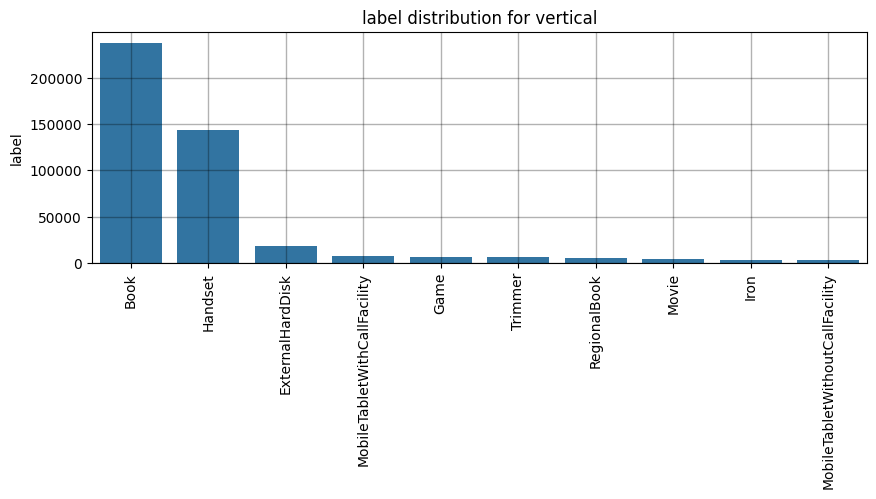

In [11]:
"""
Plot Info:
    * Net demand for each vertical on the platform

Observation:
    * Demand for Books on the platform is more than the demand for next 9 verticals combined!
"""
plot(data, "vertical", "label", topk=10, plot_type="bar", figsize=(10, 3))

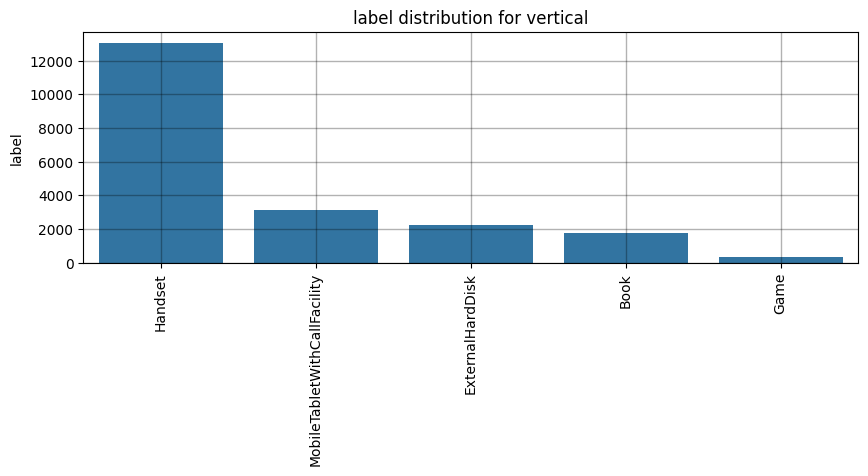

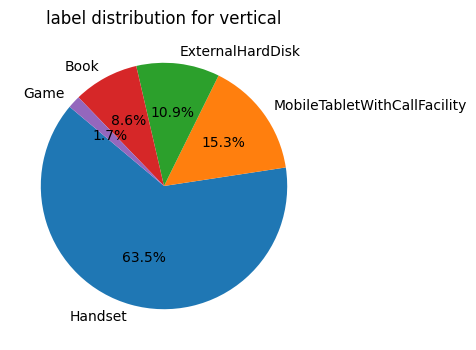

In [12]:
"""
Plot Info:
    * Number of fraud cases in the top 5 most frauded verticals (bar and pie plot)

Observation:
    * Among the top five vertical with the highest occurrence of fraud, the handset category accounts for 63% of cases.
    * Frauds in Handset vertical is more than frauds in next 4 verticals combined!!
"""
plot(
    data[data["label"] == 1],
    "vertical",
    "label",
    topk=5,
    plot_type="bar",
    figsize=(10, 3),
)
plot(
    data[data["label"] == 1],
    "vertical",
    "label",
    topk=5,
    plot_type="pie",
    figsize=(10, 4),
)

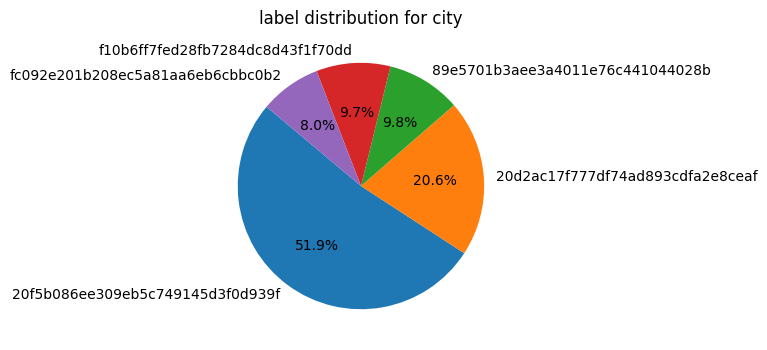

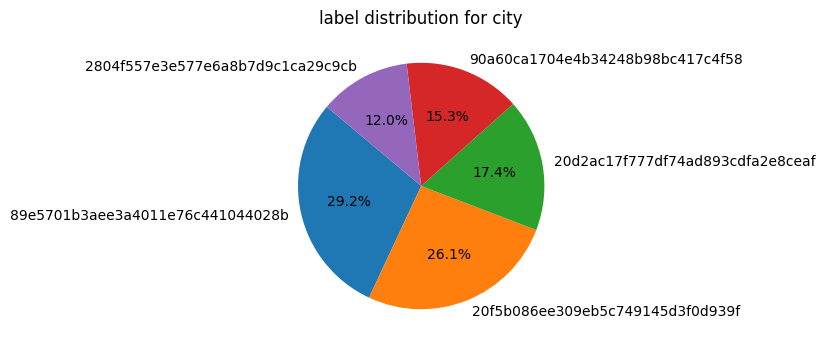

In [13]:
"""
Plot Info:
    * Plot 1 is for Fraud cases: Fraud distribution across cities
    * Plot 2 is overall: Overall demand distribution from cities

Observation: 
    * Among the top five cities with the highest occurrence of fraud, 
      '20f5b086ee309eb5c749145d3f0d939f' city accounts for 52% of cases.

    * City '89e5701b3aee3a4011e76c441044028b' seems to be the best city. 
      Brings in 29.2% demand among the top 5 cities, and only contributes to 9.8% of frauds!
"""
plot(data[data["label"] == 1], "city", "label", topk=5, plot_type="pie")
plot(data, "city", "label", topk=5, plot_type="pie")

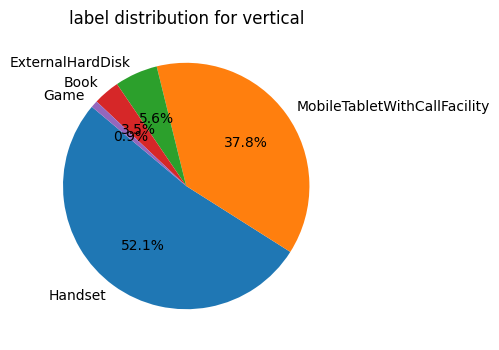

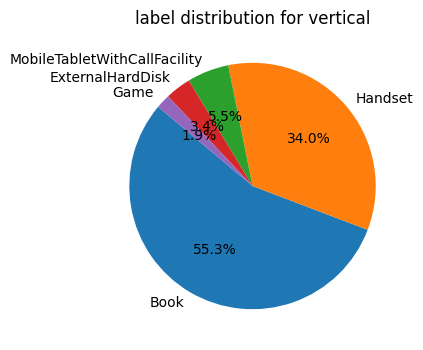

In [14]:
"""
Plot Info:
    In the most fraudulant city, i.e. "20f5b086ee309eb5c749145d3f0d939f"
    
    * Plot 1 is for Fraud cases : the share of verticals in fraud cases
    * Plot 2 is for Normal cases : the overall verticals demand in the city

Observation: 
    * 90% i.e. (52.1 + 37.9)% fraud happens in mobile phones which 
      contributes to 39.5% i.e. (34.0 + 5.5)% overall demand in the most fraudulant city!
"""
plot(
    data[(data["label"] == 1) & (data["city"] == "20f5b086ee309eb5c749145d3f0d939f")],
    "vertical",
    "label",
    topk=5,
    plot_type="pie",
)
plot(
    data[data["city"] == "20f5b086ee309eb5c749145d3f0d939f"],
    "vertical",
    "label",
    topk=5,
    plot_type="pie",
)

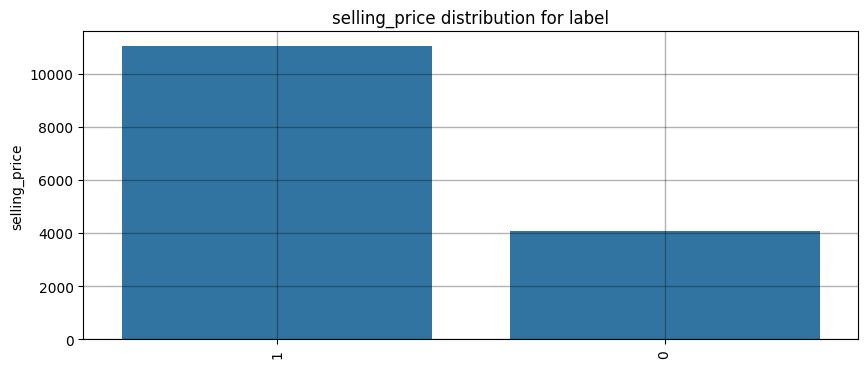

In [15]:
"""
Plot Info:
    * The average selling price across each label (1=Fraud, 0=Normal)

Observation:
    * As expected, frauds happen with expensive items.
"""
plot(data, "label", "selling_price", mode="mean", topk=5, plot_type="bar")

In [16]:
"""
FAIL: Since the data is only for 11 days, we don't find any dependence/trend in time
"""
def time_plot(
    data: pd.DataFrame,
    filter_col: List,
    time_col: List,
    agg_col: str,
    xcol_name: str,
    ycol_name: str,
    figsize: Tuple = (10, 4),
    title: str = None,
):
    """
    * Plot the count of orders for a categorical column, say, vertical, across each day of the month 
    
    time plot for the columns in "filter_col" across the 
    time (year, month, day, hour) mentioned in the "time_col"
    taking count of the "agg_col"

    filter_cols are columns with categorical variables like "vertical"    
    """
    # group by filter and time columns and calculate the count of aggregate column
    data = (
        data.groupby(filter_col + time_col)[agg_col].count().reset_index(name="count")
    )
    data.sort_values(by=filter_col + time_col, ascending=True, inplace=True)

    # aggregate all filter columns for filtering and plotting iteratively
    data["temp"] = data[filter_col[0]]
    for col in filter_col[1:]:
        data["temp"] = data["temp"] + " " + data[col]

    # plot graphs for each value in temp
    unique_values = data["temp"].unique()
    assert len(unique_values) < 10, "Can not plot more than 10 graphs.."

    for value in unique_values:
        data_cut = data[data["temp"] == value]

        # values for x axis
        x = data_cut[time_col[0]].astype(str)

        for tc in time_col[1:]:
            x = x + "-" + data_cut[tc].astype(str)

        # values for y axis
        y = data_cut["count"]

        # plot
        plt.figure(figsize=figsize)
        plt.plot(x, y, marker="o", linestyle="-")

        plt.xlabel(xcol_name)
        plt.ylabel(ycol_name)
        plt.title(f"{ycol_name} vs {xcol_name} - {value}" if title is None else title)
        plt.grid(True)

        plt.show()

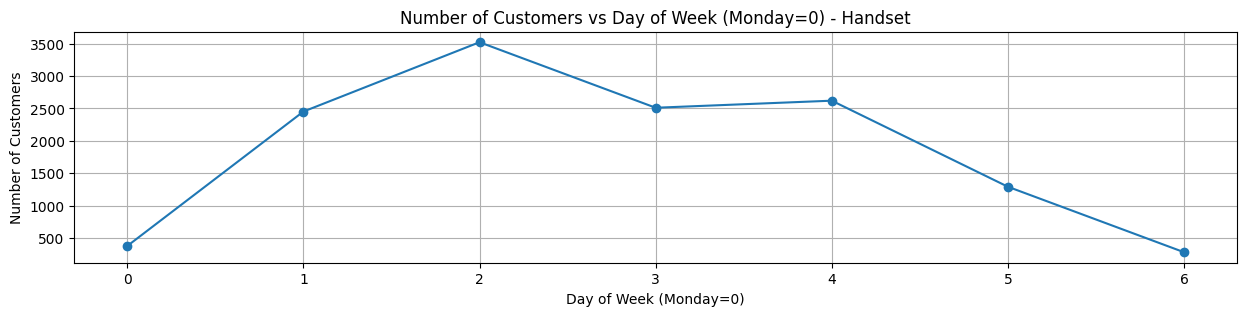

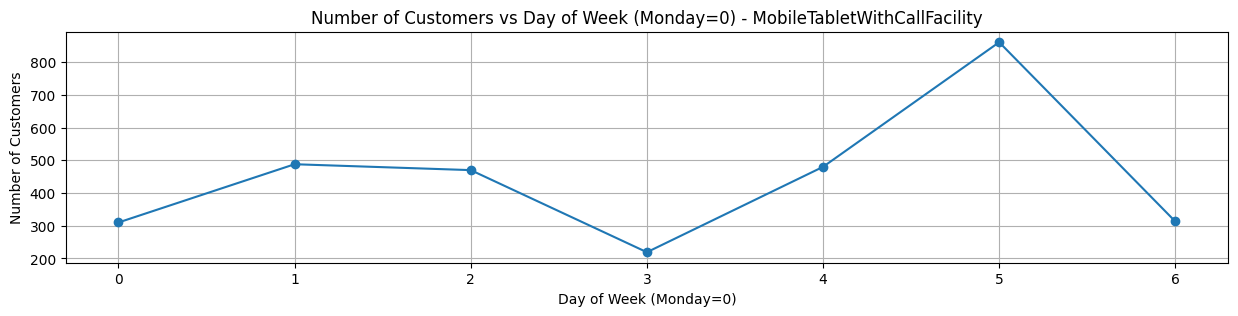

In [17]:
"""
Plot Info:
    * The count of fraud orders for 
      "Handset" and "MobileTabletWithCallFacility" vertical
      across each day of the week

Observation:
    * There is no relationship or trend that can be observed 
    (maybe because data spans only 11 days)
"""

cut = data.copy()

cut[f"order_date_weekday"] = cut["order_date"].dt.dayofweek
cut = cut[cut["label"] == 1]

time_plot(
    cut[cut["vertical"].isin(["Handset", "MobileTabletWithCallFacility"])].copy(),
    filter_col=["vertical"],
    time_col=["order_date_weekday"],
    agg_col="label",
    xcol_name="Day of Week (Monday=0)",
    ycol_name="Number of Customers",
    figsize=(15, 3),
)

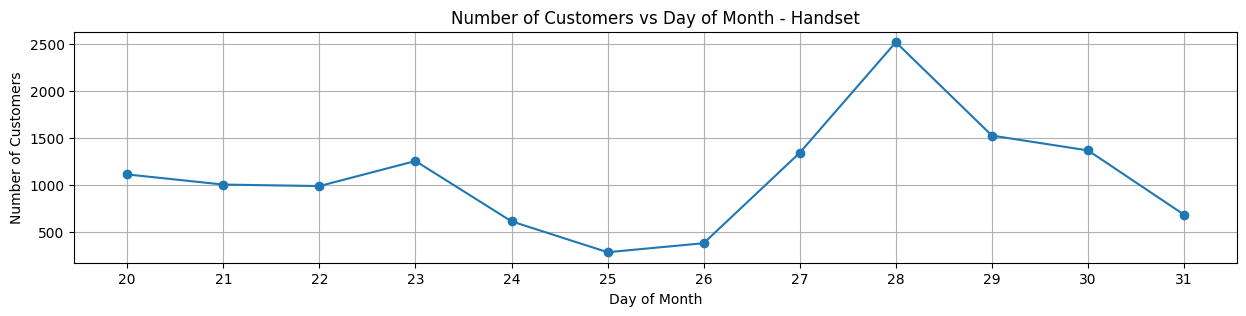

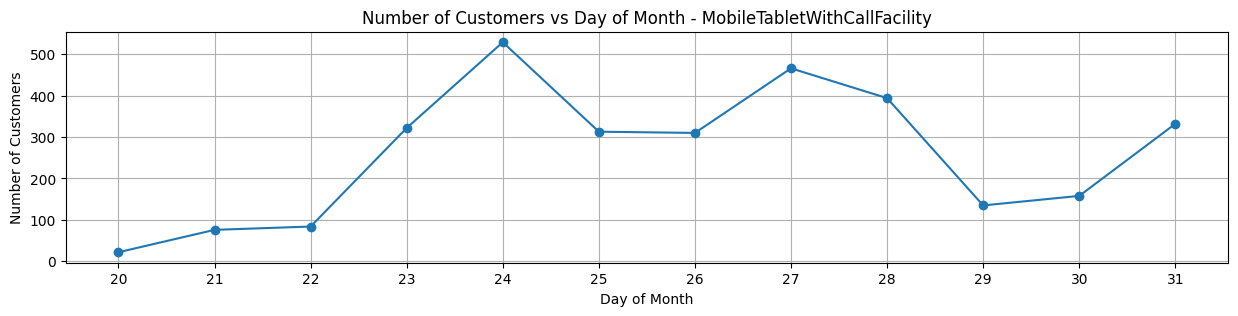

In [18]:
"""
Same plot as above but for each day of the month
"""

cut["day_of_month"] = cut["order_date"].dt.day

time_plot(
    cut[cut["vertical"].isin(["Handset", "MobileTabletWithCallFacility"])].copy(),
    filter_col=["vertical"],
    time_col=["day_of_month"],
    agg_col="label",
    xcol_name="Day of Month",
    ycol_name="Number of Customers",
    figsize=(15, 3),
)

## EDA Conclusions:

* There is no dependence observed on the time when the order was placed
* Vertical (product category) could serve as the most important feature
* Geography of the customer also has a relation with the outcome
* Selling Price of the goods could also have a decent impact

# ___________________________________________FeatureEngineering

# Time Encoding

In [66]:
"""
Though we concluded that time wouldn't play a crucial role in this particular case,
just to make the solution scalable for when we have enough data, let's still have time encoded.

Time could be an important feature when we consider data for the entire year.
It could capture seasonality, festivals and events like Big Billion Days sale!
"""

In [10]:
# Encode date in two components of Sin and Cosine
def cyclic_encoding(data, col, max_val):
    data[f"{col}_sin"] = np.sin(2 * np.pi * data[col] / max_val)
    data[f"{col}_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    return data.drop(col, axis=1)


def time_features(data, column):
    data[column] = pd.to_datetime(data[column], errors="coerce")

    data[f"{column} Month"] = data[column].dt.month
    data[f"{column} Day"] = data[column].dt.day
    data[f"{column} Hour"] = data[column].dt.hour
    data[f"{column} Weekday"] = data[column].dt.dayofweek

    max_values = [("Hour", 24), ("Month", 12), ("Day", 31), ("Weekday", 7)]

    for col_name, max_value in max_values:
        data = cyclic_encoding(data, f"{column} {col_name}", max_value)

    return data

In [11]:
time_cols = ["order_date", "user_account_created_date"]

for col in time_cols:
    data = time_features(data, col)

data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,order_date Weekday_sin,order_date Weekday_cos,user_account_created_date Hour_sin,user_account_created_date Hour_cos,user_account_created_date Month_sin,user_account_created_date Month_cos,user_account_created_date Day_sin,user_account_created_date Day_cos,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,-0.433884,-0.900969,0.707107,-7.071068e-01,0.866025,-0.5,-0.937752,0.347305,0.974928,-0.222521
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,0.974928,-0.222521,-1.000000,-1.836970e-16,-0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969


In [12]:
# Time of order since the customer has been on the platform
data["duration_days"] = round(
    (data["order_date"] - data["user_account_created_date"]) / np.timedelta64(1, "D")
)
data["duration_months"] = round(
    (data["order_date"] - data["user_account_created_date"]) / np.timedelta64(1, "M")
)
data.head(2)

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,user_account_created_date Hour_sin,user_account_created_date Hour_cos,user_account_created_date Month_sin,user_account_created_date Month_cos,user_account_created_date Day_sin,user_account_created_date Day_cos,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos,duration_days,duration_months
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,0.707107,-7.071068e-01,0.866025,-0.5,-0.937752,0.347305,0.974928,-0.222521,758.0,25.0
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,-1.000000,-1.836970e-16,-0.866025,-0.5,0.897805,-0.440394,-0.433884,-0.900969,655.0,22.0


In [13]:
# total order value, ratios of - quantity:count_14days and selling_price:(100 - discount)
data["discount_to_selling_price"] = data["selling_price"] / (100 - data["discount"])
data["quantity_to_last_14"] = data["quantity"] / data["count_14_days"]
data["total_order_value"] = data["quantity"] * data["selling_price"]
data

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,user_account_created_date Month_cos,user_account_created_date Day_sin,user_account_created_date Day_cos,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos,duration_days,duration_months,discount_to_selling_price,quantity_to_last_14,total_order_value
1,61c2c93a011a78c76d2e720120bbfd4c,7fec8d8425a12add61c7a83d8270a0cb,1,6999,2014-05-23,ndd,f1f9a2662d06cfd0abc8d2b7147ade37,2012-04-25 09:08:45,a3c2e034510ab9f992bf86ad6327fc6b,89e5701b3aee3a4011e76c441044028b,...,-5.000000e-01,-0.937752,0.347305,0.974928,-0.222521,758.0,25.0,0.000278,1.0,6999
2,4049bffb21037c1ba41064802baa86f6,59f6d6f76798b14e053f136a5c726d65,1,5589,2014-05-28,non-ndd,a3e8c45cd263e72f7001303a8b22649c,2012-08-10 18:44:49,8fc0ad66f61f9612d9aec2e0ddeebc10,64f692fc1ed662e37a49acaf1c0d0b4a,...,-5.000000e-01,0.897805,-0.440394,-0.433884,-0.900969,655.0,22.0,0.005156,1.0,5589
3,51317d4d2583de8a4813972c94637449,a57566363f05f7bba50c1f7d3d6a93f8,1,79,2014-05-27,non-ndd,beda308ae5e3bfcefd1d9394c6532bce,2012-10-19 00:56:02,ee8df0f2fb20e881eb503748fa653d29,90a60ca1704e4b34248b98bc417c4f58,...,5.000000e-01,-0.651372,-0.758758,-0.433884,-0.900969,585.0,19.0,0.326076,0.5,79
4,25bc2ec67785edcfa5f93ee14023bf8b,3a54c84b0446bf27d46df55edb48c2e1,1,147,2014-05-27,non-ndd,beda308ae5e3bfcefd1d9394c6532bce,2012-10-19 00:56:02,ee8df0f2fb20e881eb503748fa653d29,90a60ca1704e4b34248b98bc417c4f58,...,5.000000e-01,-0.651372,-0.758758,-0.433884,-0.900969,585.0,19.0,0.238905,1.0,147
5,775064069bc349b42080a86d2792f4c7,d4eb6f495c826f6b5db7e5a06f986f5c,1,4225,2014-05-29,non-ndd,788da8e6b5f1ea8e12db5ded8a56f98f,2013-06-21 13:38:12,c407732fc10c0bcda72341dc374f036f,20f5b086ee309eb5c749145d3f0d939f,...,-1.000000e+00,-0.897805,-0.440394,-0.433884,-0.900969,341.0,11.0,0.008789,1.0,4225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481102,e0b83d3be185dd55ffd6b2324fe1d5cb,5b29b833e8f203c74635088befaaa504,1,404,2014-05-20,non-ndd,ce7015d99c861c4a87900cec1b9b64ac,2013-03-09 12:20:11,172bf00f1a124104fbe27e070528f2c4,33cafd76c46603279492f9c05082db62,...,6.123234e-17,0.968077,-0.250653,-0.974928,-0.222521,436.0,14.0,0.078022,1.0,404
481103,b704435595e0f78b4f50f900a987072e,bac7cc0eaad43a4d3066ddbd3eefe888,1,160,2014-05-25,non-ndd,9de0aaa6bf19578b2aa843c3b3d511d1,2012-09-30 08:30:10,7f95afd036e5b78bbf0ee0b164ff4b37,20f5b086ee309eb5c749145d3f0d939f,...,-1.836970e-16,-0.201299,0.979530,-0.781831,0.623490,602.0,20.0,0.157500,0.5,160
481104,7adc209db7a5c7803b198cca84d53fe3,603d11196ef1163014545b7d58cc5f6a,1,143,2014-05-25,non-ndd,9de0aaa6bf19578b2aa843c3b3d511d1,2012-09-30 08:30:10,7f95afd036e5b78bbf0ee0b164ff4b37,20f5b086ee309eb5c749145d3f0d939f,...,-1.836970e-16,-0.201299,0.979530,-0.781831,0.623490,602.0,20.0,0.022860,0.5,143
481105,f5eaa99489a48485b17b1ef9d2f79611,f31485c68d0a6670a04c702dec44f546,1,1500,2014-05-30,non-ndd,792b3ff717f4faef0a067b5d629e9e35,2013-08-18 12:05:57,f5a38d79342eb7199e87e448e30860bb,fb67d4b49f58da3adf332a25c7f3f23a,...,-5.000000e-01,-0.485302,-0.874347,-0.781831,0.623490,284.0,9.0,0.000000,1.0,1500


# Train Test Split

In [14]:
# reserve last 1 day for test
data.sort_values(by=["order_date"], ascending=True, inplace=True)
threshold_date = data["order_date"].max() - timedelta(days=1)

train = data[data["order_date"] <= threshold_date]
test = data[data["order_date"] > threshold_date]

len(train), len(test)

(435020, 26883)

In [15]:
len(set(test.user_id).intersection(train.user_id))

1927

In [16]:
test.user_id.nunique()

18299

In [17]:
# feature engineering: mean of below columns at a product/vertical level
columns = ["quantity", "count_14_days", "count_28_days"]

for column in columns:
    features = train.groupby("product_id")[column].mean().reset_index(name=f"{column}_mean")
    train = train.merge(features, how="left")
    test = test.merge(features, how="left")

    # fill NaNs from vertical mean
    features = train.groupby("vertical")[column].mean().reset_index(name=f"{column}_mean_imputation")
    test = test.merge(features, how="left")
    test[f"{column}_mean"] = np.where(test[f"{column}_mean"].isnull(), test[f"{column}_mean_imputation"], test[f"{column}_mean"])
    del test[f"{column}_mean_imputation"]

    # fill NaNs with mean of the column in train
    test[f"{column}_mean"].fillna(train[column].mean(), inplace=True)

test

,order_id,product_id,quantity,selling_price,order_date,shipping_type,user_id,user_account_created_date,address_id,city,...,user_account_created_date Weekday_sin,user_account_created_date Weekday_cos,duration_days,duration_months,discount_to_selling_price,quantity_to_last_14,total_order_value,quantity_mean,count_14_days_mean,count_28_days_mean
0,20c36af18ea6d8c939a76601504e800f,a0f46fe61d84bec6f13af17ab6cdd94c,1,2499,2014-05-31,non-ndd,2acf361fcba00ed706de11c347889638,2011-09-16 21:13:12,54aed260a683f9fdd049647dff751a8f,90a60ca1704e4b34248b98bc417c4f58,...,-0.433884,-0.900969,987.0,32.0,0.008560,1.000000,2499,1.000000,1.000000,1.000000
1,a10ed6dfe57891d59f276a3fcb1d8829,8e4b6d458d800de71b40a7651276558d,1,71,2014-05-31,non-ndd,b99f871c44277fa761b67f9f556fdb09,2013-05-10 15:10:36,a13c26ade696a3aa39596713d9afb29c,c02e660e379adff2474ad41a6939fe91,...,-0.433884,-0.900969,385.0,13.0,0.412113,0.500000,71,2.252252,765.189189,765.189189
2,ee02475579a65d5d4c7a04f7ab53c05a,e77ea54fa053ea97d9cf8126c4609407,1,3999,2014-05-31,non-ndd,5fd39f564105ae80834b4f3c17992dfe,2014-05-31 21:55:53,9a68519e2b96bbd019afd9f55362f2eb,20f5b086ee309eb5c749145d3f0d939f,...,-0.974928,-0.222521,-1.0,-0.0,0.014004,1.000000,3999,1.000000,1.648343,1.648343
3,70cebfd4eb7f81dd587ab6ea00831b7b,4732ce55c9c537536b8dde067ce86d5f,1,546,2014-05-31,non-ndd,18a946b368bd060ec7751ccf891c4eda,2013-06-22 15:10:40,582de12f5857c37a088ae5db766eb7e0,eb7ebc2f02d005dac3d541a35e261003,...,-0.974928,-0.222521,342.0,11.0,0.054449,1.000000,546,1.018223,1.079727,1.079727
4,f73fc7f23fcfc68ca068f365a7ab15a8,f63bad59151d8c33d9d8c195c071bbfe,1,197,2014-05-31,non-ndd,b99f871c44277fa761b67f9f556fdb09,2013-05-10 15:10:36,a13c26ade696a3aa39596713d9afb29c,c02e660e379adff2474ad41a6939fe91,...,-0.433884,-0.900969,385.0,13.0,0.044203,0.500000,197,1.894737,445.842105,445.842105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26878,999d114a419f904cbee852a1c0621fd5,ea59b11d4bea2fa3afdc0bd8719a39e9,1,151,2014-05-31,non-ndd,58f780d9c9c36e2a302cc3d0330f74e6,2012-04-10 11:36:51,bb87cdd5a967ec827aa977b363b3c922,0ddc8d578a7b720ab49fcff2e6929885,...,0.781831,0.623490,781.0,26.0,0.051828,0.333333,151,1.000000,9.800000,9.800000
26879,0310e6c1c0c0d715dbae4e5816b8bfbf,e77ea54fa053ea97d9cf8126c4609407,1,3999,2014-05-31,non-ndd,de6527241ea7b3e05c6f4418e087587d,2011-10-24 18:39:07,77d3e55c1bf9aee7557877ce9b4df0f0,2804f557e3e577e6a8b7d9c1ca29c9cb,...,0.000000,1.000000,949.0,31.0,0.014004,1.000000,3999,1.000000,1.648343,1.648343
26880,22a6218020c5c4050784d8f4789b8520,e6e3e28d3c8d5c7c87407ee6d6a609db,1,7299,2014-05-31,non-ndd,b273c68dc3af1d3d37e34c120955f0c2,2014-04-27 20:24:04,e1c7cdbdff8d7532f29fb65e7cdd38f3,ebf1f436c023d8bc83963ea4628a949e,...,-0.781831,0.623490,33.0,1.0,0.003389,1.000000,7299,1.000000,3.664581,3.664581
26881,2f7515bcebf7de4f672f404864c74228,f1ed724c5b2a112c82df98a93536e584,1,4345,2014-05-31,non-ndd,3e9986fbccaf5645aaebdba895695dc0,2014-03-02 14:39:43,1738011073cf58b74df650d782bc9275,7a3b6287a8dce074caa1d1a6b2a02cca,...,-0.781831,0.623490,89.0,3.0,0.012221,1.000000,4345,1.000000,3.038320,3.038320


# Response Encoding

In [18]:
def running_response_encoding(data, column, time_column, label="label", alpha=1, beta=1):
    """
    Computes the encoded values for each unique value in the grouping column, 
    considering the label column as the response variable.

    Parameters:
    - data (DataFrame): The input DataFrame containing the data to be encoded.
    - column (str): The name of the grouping column for which encoding is to be calculated.
    - time_column (str): The name of the time column used for sorting the data.
    - label (str, optional): The name of the label column, default is "label".
    - alpha (float, optional): Smoothing parameter (Laplace smoothing) for numerator, default is 1.
    - beta (float, optional): Smoothing parameter (Laplace smoothing) for denominator, default is 1.

    Returns:
    - data (DataFrame): The input DataFrame with additional columns containing the running
      response encoding values for the specified grouping column.
    """
    data = data.sort_values(by=[time_column, column], ascending=True)

    data[f"{column}_numerator"] = data.groupby(column)[label].shift(1)
    data[f"{column}_numerator"].fillna(0, inplace=True)
    data[f"{column}_numerator"] = data.groupby(column)[f"{column}_numerator"].cumsum()
    
    data[f"{column}_denominator"] = data.groupby([column])[label].cumcount()
    data[f"{column}_encoded"] = (data[f"{column}_numerator"] + alpha) / (data[f"{column}_denominator"] + alpha + beta)

    return data


alpha = 0.048
beta = 0.952


categorical_columns = ["user_id"]

for column in categorical_columns:
    train = running_response_encoding(data=train, 
                                      column=column, 
                                      time_column="order_date", 
                                      label="label", 
                                      alpha=alpha, 
                                      beta=beta)


    append = train.groupby(column, sort=False).tail(1).copy()
    append[f"{column}_numerator"] += append["label"]
    append[f"{column}_denominator"] += 1
    append[f"{column}_encoded"] = (append[f"{column}_numerator"] + alpha) / (append[f"{column}_denominator"] + alpha + beta)
    
    append = append[[column, f"{column}_numerator", f"{column}_denominator", f"{column}_encoded"]].copy()
    test = test.merge(append, how="left")
    
    test[f"{column}_numerator"].fillna(alpha, inplace=True)
    test[f"{column}_denominator"].fillna(alpha + beta, inplace=True)
    test[f"{column}_encoded"].fillna(alpha / (alpha + beta), inplace=True)

In [19]:
def response_encoding(data, column, label="label", alpha=1, beta=1):
    """
    Encode categorical data based on the response rate for each category.

    Parameters:
        - data (pd.DataFrame): The input DataFrame containing the data.
        - column (str): The name of the categorical column to encode.
        - label (str): The name of the response label column (default is "label").

    Returns:
        - dict: A dictionary containing the encoded values for each category.
    """
    value_counts = data.groupby(column)[label].value_counts().reset_index(name="count")

    x = data[[column]].drop_duplicates()
    y = data[[label]].drop_duplicates()

    x["temp"] = 0
    y["temp"] = 0

    temp = pd.merge(x, y, on=["temp"])
    temp.drop(columns=["temp"], inplace=True)
    temp.sort_values(by=[column, label], inplace=True, ascending=True)

    value_counts = temp.merge(value_counts, how="left")
    value_counts.fillna(0, inplace=True)

    numerator = value_counts.groupby(column, sort=False)["count"].apply(np.array)
    denominator = value_counts.groupby(column, sort=False)["count"].sum()

    value_counts = ((numerator + alpha) / (denominator + alpha + beta)).apply(lambda x: x.tolist())
    return value_counts.to_dict()
    
categorical_columns = [
    "product_id",
    "shipping_type",
    "city",
    "pincode",
    "vertical",
]
categorical_encoding = {
    column: response_encoding(train, column, alpha=alpha, beta=beta) for column in tqdm(categorical_columns)
}

100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


In [20]:
categorical_encoding["shipping_type"]

{'ndd': [0.8923918788670211, 0.10760812113297889],
 'non-ndd': [0.9585212618869723, 0.0414787381130277]}

# Aggregate Features

Cyclic Features + Categorical Features + Numerical Features

In [21]:
def aggregate_categorical_features(data):
    func = lambda column: data[column].map(
        lambda x: categorical_encoding[column].get(x, [0, 0])
    )

    categorical_features = func(categorical_columns[0])

    for cat_col in categorical_columns[1:]:
        categorical_features += func(cat_col)

    return categorical_features


train_categorical_features = aggregate_categorical_features(train).reset_index(
    drop=True
)
test_categorical_features = aggregate_categorical_features(test).reset_index(drop=True)

In [22]:
test_categorical_features

0        [1.0, 0.0, 0.9585212618869723, 0.0414787381130...
1        [0.963963963963964, 0.036036036036036036, 0.95...
2        [0.8424513413992636, 0.15754865860073644, 0.95...
3        [0.9954441913439636, 0.004555808656036446, 0.9...
4        [0.9824561403508771, 0.017543859649122806, 0.9...
                               ...                        
26878    [1.0, 0.0, 0.9585212618869723, 0.0414787381130...
26879    [0.8424513413992636, 0.15754865860073644, 0.95...
26880    [0.8785982478097623, 0.1214017521902378, 0.958...
26881    [0.812822402358143, 0.18717759764185704, 0.958...
26882    [0.8785982478097623, 0.1214017521902378, 0.958...
Name: product_id, Length: 26883, dtype: object

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435020 entries, 26562 to 378796
Data columns (total 67 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   order_id                               435020 non-null  object        
 1   product_id                             435020 non-null  object        
 2   quantity                               435020 non-null  int64         
 3   selling_price                          435020 non-null  int64         
 4   order_date                             435020 non-null  datetime64[ns]
 5   shipping_type                          435020 non-null  object        
 6   user_id                                435020 non-null  object        
 7   user_account_created_date              435020 non-null  datetime64[ns]
 8   address_id                             435020 non-null  object        
 9   city                                   43502

In [24]:
cyclic_columns = list(data.columns[40:56])
cyclic_columns

['order_date Hour_sin',
 'order_date Hour_cos',
 'order_date Month_sin',
 'order_date Month_cos',
 'order_date Day_sin',
 'order_date Day_cos',
 'order_date Weekday_sin',
 'order_date Weekday_cos',
 'user_account_created_date Hour_sin',
 'user_account_created_date Hour_cos',
 'user_account_created_date Month_sin',
 'user_account_created_date Month_cos',
 'user_account_created_date Day_sin',
 'user_account_created_date Day_cos',
 'user_account_created_date Weekday_sin',
 'user_account_created_date Weekday_cos']

In [25]:
features_columns = train.select_dtypes(include=["float64", "int64"]).columns
features_columns = features_columns.drop("label")
numerical_columns = list(features_columns.difference(cyclic_columns))
numerical_columns

['category_purchase_count_X26x',
 'category_purchase_count_X2oq',
 'category_purchase_count_X4kt',
 'category_purchase_count_X4rr',
 'category_purchase_count_X6bo',
 'category_purchase_count_amz',
 'category_purchase_count_bks',
 'category_purchase_count_ckf',
 'category_purchase_count_dep',
 'category_purchase_count_dgv',
 'category_purchase_count_ixq',
 'category_purchase_count_j9e',
 'category_purchase_count_jek',
 'category_purchase_count_kyh',
 'category_purchase_count_mcr',
 'category_purchase_count_mgl',
 'category_purchase_count_osp',
 'category_purchase_count_r18',
 'category_purchase_count_reh',
 'category_purchase_count_t06',
 'category_purchase_count_tyy',
 'category_purchase_count_vdm',
 'count_14_days',
 'count_14_days_mean',
 'count_28_days',
 'count_28_days_mean',
 'count_56_days',
 'discount',
 'discount_to_selling_price',
 'duration_days',
 'duration_months',
 'quantity',
 'quantity_mean',
 'quantity_to_last_14',
 'selling_price',
 'total_order_value',
 'user_id_denom

In [26]:
feature_columns = numerical_columns + cyclic_columns

In [27]:
y_train = train["label"]
X_train = pd.Series(train[feature_columns].values.tolist()) + train_categorical_features

y_test = test["label"]
X_test = pd.Series(test[feature_columns].values.tolist()) + test_categorical_features

In [28]:
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

In [29]:
X_train, y_train

(array([[0.00000000e+00, 3.70000000e+01, 0.00000000e+00, ...,
         5.22088353e-02, 9.92198870e-01, 7.80112994e-03],
        [0.00000000e+00, 3.70000000e+01, 0.00000000e+00, ...,
         5.22088353e-02, 9.92198870e-01, 7.80112994e-03],
        [0.00000000e+00, 3.70000000e+01, 0.00000000e+00, ...,
         5.22088353e-02, 9.92198870e-01, 7.80112994e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.10210210e-02, 9.10848294e-01, 8.91517058e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 9.10848294e-01, 8.91517058e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.63934426e-02, 9.10848294e-01, 8.91517058e-02]]),
 26562     0
 26563     0
 26565     0
 26566     0
 26569     0
          ..
 418311    0
 423650    0
 405578    0
 395993    0
 378796    0
 Name: label, Length: 435020, dtype: int64)

# SMOTE

SMOTE wouldn't make much of a difference with XGBoost and Random Forest

However, MLP could really use some class balancing

In [30]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [31]:
counter = Counter(y_train)
counter

Counter({0: 414849, 1: 20171})

In [32]:
"""
Define the resampling strategies and ratios

    * RandomUnderSampler will reduce the number of samples for class 0 to 200,000
    * SMOTE will increase the number of samples for class 1 to 40,000
"""
under = RandomUnderSampler(sampling_strategy={0: 300000})
over = SMOTE(sampling_strategy={1: 100000})

# The pipeline first applies SMOTE (oversampling) and then RandomUnderSampler (undersampling)
# steps = [("o", over), ("u", under)]
steps = [("u", under)]
pipeline = Pipeline(steps=steps)

# Apply the resampling pipeline to the training data (X_train and y_train)
# This step will balance the class distribution by oversampling class 1 and undersampling class 0
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [33]:
counter = Counter(y_train)
counter

Counter({0: 300000, 1: 20171})

# Metrics
__________

In [34]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from prettytable import PrettyTable

In [35]:
class Metrics:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.results = dict()

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def plot_roc_curve(self, model, plot=True):
        """
        Plots the Receiver Operating Characteristic (ROC) curve for a binary classification model.

        Parameters:
            - model: The binary classification model.
            - X_test: Testing data features.
            - y_test: True labels for testing data.
            - plot (bool): Whether to display the ROC curve plot (default is True).

        Returns:
            - float: Area under the ROC curve (AUC) score.
        """
        y_scores = model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_scores)

        roc_auc = auc(fpr, tpr)

        if plot:
            plt.figure(figsize=(8, 6))

            plt.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=2,
                label="ROC curve (area = {:.2f})".format(roc_auc),
            )
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])

            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()

        return roc_auc

    def model_stats(self, model, model_name, plot_auc=False):
        """
        Computes and stores various model performance metrics.

        Parameters:
            - model: The classification model.
            - model_name (str): A name or identifier for the model.
            - plot_auc (bool): Whether to plot the ROC curve (default is False).

        Returns:
            - None
        """
        # Training Accuracy
        dtrain_predictions = model.predict(self.X_train)
        train_accuracy = accuracy_score(self.y_train, dtrain_predictions)

        # Testing Accuracy
        dtest_predictions = model.predict(self.X_test)
        test_accuracy = accuracy_score(self.y_test, dtest_predictions)

        # F1 Score
        train_f1_score = f1_score(self.y_train, dtrain_predictions, average="weighted")
        test_f1_score = f1_score(self.y_test, dtest_predictions, average="weighted")

        # Confusion Matrix
        tn, fp, fn, tp = confusion_matrix(self.y_test, dtest_predictions).ravel()

        # plot ROC
        roc_auc = self.plot_roc_curve(model, plot=plot_auc)

        # store results
        results = {
            # "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
            # "Train F1": train_f1_score,
            "Test F1": test_f1_score,
            "Test AUC": roc_auc,
            "True Positive": tp,
            "True Negative": tn,
            "False Positive": fp,
            "False Negative": fn,
        }

        self.results[model_name] = results
        print(self.print_results(model_name))

    def print_results(self, model_name):
        assert (
            model_name in self.results
        ), "Please run model_stats for this model before printing the results.."

        x = PrettyTable()

        x.field_names = list(self.results[model_name].keys())
        x.add_row(
            [round(value, 8) for value in list(self.results[model_name].values())]
        )
        return x

In [36]:
model_metrics = Metrics(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [37]:
import torch


def feature_importance(model, map, plot=True):
    imp = torch.from_numpy(x_clf.feature_importances_)
    values, idx = torch.sort(imp, descending=True)

    if not plot:
        print([[map[i], v.item()] for i, v in zip(idx, values)])

    else:
        plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
        plt.barh([map[i] for i in idx.tolist()], values.tolist(), color='skyblue')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature Name')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
        plt.show()

# ___________________________________________________Modelling

**Choices:**

* Ensemble methods like Random Forest and XGBoost often perform well out of the box and should be considered for their robustness

* Deep learning models like Feed Forward Neural Networks can be powerful but may require more data and computational resources
* Logistic Regression serves as a good starting point and a reference for simpler models

## XGBoost

In [38]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [39]:
x_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=2,
    colsample_bytree=1,
    max_depth=100,
    subsample=0.3,
)

x_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=100, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [40]:
model_metrics.model_stats(x_clf, "XGBoost", plot_auc=False)

+---------------+------------+------------+---------------+---------------+----------------+----------------+
| Test Accuracy |  Test F1   |  Test AUC  | True Positive | True Negative | False Positive | False Negative |
+---------------+------------+------------+---------------+---------------+----------------+----------------+
|   0.97734628  | 0.97496971 | 0.95564461 |      701      |     25573     |       85       |      524       |
+---------------+------------+------------+---------------+---------------+----------------+----------------+


## Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier(
    n_jobs=-1, bootstrap=True, n_estimators=1000, max_depth=20, class_weight="balanced"
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=1000,
                       n_jobs=-1)

In [45]:
model_metrics.model_stats(rf, "Random Forest", plot_auc=False)

+---------------+------------+-----------+---------------+---------------+----------------+----------------+
| Test Accuracy |  Test F1   |  Test AUC | True Positive | True Negative | False Positive | False Negative |
+---------------+------------+-----------+---------------+---------------+----------------+----------------+
|   0.98080571  | 0.98002543 | 0.9700235 |      871      |     25496     |      162       |      354       |
+---------------+------------+-----------+---------------+---------------+----------------+----------------+


## Logistic Regression

### (Fail)

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
lreg = LogisticRegression(C=100)
lreg.fit(X_train, y_train)

/Users/dawn/git/vision/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [49]:
model_metrics.model_stats(lreg, "Logistic Regression", plot_auc=False)

+---------------+------------+------------+---------------+---------------+----------------+----------------+
| Test Accuracy |  Test F1   |  Test AUC  | True Positive | True Negative | False Positive | False Negative |
+---------------+------------+------------+---------------+---------------+----------------+----------------+
|   0.95432057  | 0.93248752 | 0.74023914 |       5       |     25650     |       8        |      1220      |
+---------------+------------+------------+---------------+---------------+----------------+----------------+


## MLP

In [51]:
import os
import math
import warnings
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
torch.manual_seed(0)

In [52]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


# Define a custom dataset class named CDataset
class CDataset(Dataset):
    def __init__(self, x, y):
        """
        Initialize a custom dataset.

        Parameters:
            - x (numpy.ndarray): Input features.
            - y (numpy.ndarray): Target labels.
        """
        self.x = x
        self.y = y

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns:
            - int: The number of samples.
        """
        return len(self.x)

    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.

        Parameters:
            - idx (int): Index of the sample to retrieve.

        Returns:
            - torch.Tensor: The input features as a torch tensor.
            - torch.Tensor: The target label as a torch tensor.
        """
        features = self.x[idx]
        target = self.y[idx]

        return torch.tensor(features, dtype=torch.float32), torch.LongTensor([target]).squeeze(-1)


# Define batch size
BATCH_SIZE = 64

# Create CDataset instances for training and testing
cdata_train = CDataset(X_train, np.array(y_train))
cdata_test = CDataset(X_test, np.array(y_test))

# Create DataLoader for training data
train_dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=0)
trainloader = DataLoader(cdata_train, pin_memory=True, **train_dataloader_args)

# Create DataLoader for testing data
test_dataloader_args = dict(shuffle=False, batch_size=5000, num_workers=0)
testloader = DataLoader(cdata_test, pin_memory=True, **test_dataloader_args)

In [53]:
len(cdata_train[0][0])

65

In [54]:
import torch
import torch.nn as nn
import numpy as np


class FeedForwardNet(nn.Module):
    def __init__(self, ndimension, ntarget, device, dropout=0.1):
        """
        Initializes a FeedForwardNet instance.

        Parameters:
            - ndimension (int): The input dimension of the neural network.
            - ntarget (int): The output dimension of the neural network.
            - device (torch.device): The device (CPU or GPU or mps) on which the model will be run.
            - dropout (float): Dropout probability for the network's dropout layers (default is 0.1).
        """
        super().__init__()

        # Create the layers of the neural network
        layer1 = self._get_layer(ndimension, 128, dropout)
        layer2 = self._get_layer(128, 64, dropout)
        layer3 = nn.Linear(64, ntarget, bias=False)

        # Define the neural network as a sequence of layers
        self.layer = nn.Sequential(*[layer1, layer2, layer3])
        self.device = device

    def _get_layer(self, in_dim, out_dim, dropout=0.1):
        """
        Creates a single layer of the neural network, consisting of a linear layer, 
        ReLU activation, LayerNorm and dropout.

        Parameters:
            - in_dim (int): The input dimension of the layer.
            - out_dim (int): The output dimension of the layer.
            - dropout (float): Dropout probability for the layer (default is 0.1).

        Returns:
            - nn.Sequential: A sequential container for the layer components.
        """
        return nn.Sequential(
            nn.Linear(in_dim, out_dim, bias=False),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, input_vec):
        """
        Forward pass of the neural network.

        Parameters:
            - input_vec (torch.Tensor): The input data tensor.

        Returns:
            - torch.Tensor: The output tensor produced by the network.
        """
        return self.layer(input_vec)

    def predict(self, input_vec: np.array, proba=False):
        """
        Make predictions using the neural network.

        Parameters:
            - input_vec (np.array): Input data for making predictions.
            - proba (bool): If True, return class probabilities; otherwise, return class labels (default is False).

        Returns:
            - np.array: Predicted class labels or class probabilities.
        """
        self.eval()

        batch_size = 500
        num_batches = len(input_vec) // batch_size + int(
            len(input_vec) % batch_size > 0
        )
        batches = np.array_split(input_vec, num_batches, axis=0)

        prediction = []

        with torch.no_grad():
            for i, src in enumerate(batches):
                src = torch.tensor(src, dtype=torch.float32).to(self.device)

                output = self(src.float())

                if proba:
                    prediction.extend(torch.softmax(output, dim=-1).tolist())
                else:
                    prediction.extend(output.argmax(-1).tolist())

        return np.array(prediction)

    def predict_proba(self, input_vec: np.array):
        """
        Make probability predictions using the neural network.

        Parameters:
            - input_vec (np.array): Input data for making probability predictions.

        Returns:
            - np.array: Predicted class probabilities.
        """
        return self.predict(input_vec, proba=True)

In [55]:
device = torch.device("mps")
model = FeedForwardNet(
    ndimension=len(cdata_train[0][0]), ntarget=2, dropout=0.1, device=device
).to(device)

In [56]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [57]:
from tqdm import tqdm


def train(epoch, model, device, trainloader, optimizer, scheduler):
    """
    Train the neural network model for one epoch.

    Parameters:
        - epoch (int): The current epoch number.
        - model (nn.Module): The neural network model to be trained.
        - device (torch.device): The device (CPU or GPU or mps) to run the training on.
        - trainloader (DataLoader): DataLoader for training data.
        - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
    """
    model.train()

    running_loss = 0
    running_accuracy = 0

    correct = 0
    processed = 0
    pbar = tqdm(trainloader)

    for i, (src, trg) in enumerate(pbar, 0):
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src.float())

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()
        scheduler.step()

        pred = output.argmax(-1)
        correct += pred.eq(trg.view_as(pred)).sum().item()
        processed += len(pred)

        running_loss += loss.item()
        

    # Print training statistics for the epoch
    print(
        f"Train Epoch - {epoch + 1}, Mini Batch - {i + 1}, "
        f"Train Loss - {round(running_loss / (i+1), 4)}, "
        f"Train Accuracy - {round(100 * correct / processed, 4)}"
    )
    return running_loss / len(trainloader)

In [58]:
def test(model, device, testloader):
    """
    Evaluate the neural network model on the test data.

    Parameters:
        - model: The trained neural network model.
        - device (torch.device): The device (CPU or GPU or mps) to run the evaluation on.
        - testloader (DataLoader): DataLoader for test data.

    Returns:
        - None
    """
    model.eval()

    iterator = 0
    test_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(testloader, disable=True)

    with torch.no_grad():
        for i, (src, trg) in enumerate(pbar, 0):
            src, trg = src.to(device), trg.to(device)

            output = model(src.float())

            loss = criterion(output, trg)
            test_loss += loss.item()

            pred = output.argmax(-1)
            correct += pred.eq(trg.view_as(pred)).sum().item()
            processed += len(pred)

        print(
            f"Test Loss - {round(test_loss / (i+1), 4)}, ",
            f"Test Accuracy - {round(100 * correct / processed, 4)}",
        )
        return test_loss / len(testloader)

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.43it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.92E-03


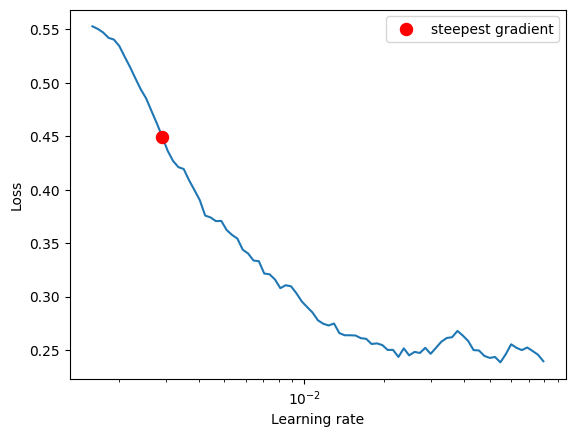

In [59]:
from torch_lr_finder import LRFinder

EPOCHS = 10

def find_lr():
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(trainloader, end_lr=0.1, num_iter=100, step_mode='exp')
    
    _, best_lr = lr_finder.plot()
    lr_finder.reset()
    
    return best_lr 


scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=find_lr(),
            steps_per_epoch=len(trainloader),
            epochs=EPOCHS,
            pct_start=5 / EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [60]:
for epoch in range(EPOCHS):
    train_loss = train(epoch, model, device, trainloader, optimizer, scheduler)
    test_loss = test(model, device, testloader)

100%|██████████████████████████████████████████████████████████| 5003/5003 [00:27<00:00, 178.81it/s]


Train Epoch - 1, Mini Batch - 5003, Train Loss - 0.2185, Train Accuracy - 92.4281
Test Loss - 0.1025,  Test Accuracy - 96.6187


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 178.29it/s]


Train Epoch - 2, Mini Batch - 5003, Train Loss - 0.1431, Train Accuracy - 95.0136
Test Loss - 0.1143,  Test Accuracy - 97.132


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 178.15it/s]


Train Epoch - 3, Mini Batch - 5003, Train Loss - 0.1353, Train Accuracy - 95.2354
Test Loss - 0.0857,  Test Accuracy - 96.5703


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:27<00:00, 179.54it/s]


Train Epoch - 4, Mini Batch - 5003, Train Loss - 0.13, Train Accuracy - 95.4402
Test Loss - 0.085,  Test Accuracy - 96.1314


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:27<00:00, 179.15it/s]


Train Epoch - 5, Mini Batch - 5003, Train Loss - 0.1249, Train Accuracy - 95.6342
Test Loss - 0.0958,  Test Accuracy - 96.5629


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 178.57it/s]


Train Epoch - 6, Mini Batch - 5003, Train Loss - 0.1171, Train Accuracy - 95.8894
Test Loss - 0.092,  Test Accuracy - 97.0093


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:27<00:00, 178.70it/s]


Train Epoch - 7, Mini Batch - 5003, Train Loss - 0.1066, Train Accuracy - 96.2889
Test Loss - 0.0694,  Test Accuracy - 97.2622


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 178.03it/s]


Train Epoch - 8, Mini Batch - 5003, Train Loss - 0.0985, Train Accuracy - 96.6021
Test Loss - 0.0734,  Test Accuracy - 97.0018


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 178.14it/s]


Train Epoch - 9, Mini Batch - 5003, Train Loss - 0.0918, Train Accuracy - 96.8576
Test Loss - 0.0679,  Test Accuracy - 97.8499


100%|██████████████████████████████████████████████████████████| 5003/5003 [00:28<00:00, 177.82it/s]


Train Epoch - 10, Mini Batch - 5003, Train Loss - 0.0843, Train Accuracy - 97.1381
Test Loss - 0.0596,  Test Accuracy - 98.0471


In [61]:
model_metrics.model_stats(model, "MLP", plot_auc=False)

+---------------+-----------+------------+---------------+---------------+----------------+----------------+
| Test Accuracy |  Test F1  |  Test AUC  | True Positive | True Negative | False Positive | False Negative |
+---------------+-----------+------------+---------------+---------------+----------------+----------------+
|   0.98047093  | 0.9797707 | 0.97517542 |      877      |     25481     |      177       |      348       |
+---------------+-----------+------------+---------------+---------------+----------------+----------------+


## Ensemble

In [67]:
from typing import List
from scipy import stats


class Ensemble:
    def __init__(self, models: List):
        """
        Initialize an ensemble of models.

        Parameters:
            - models (List): A list of models to be used in the ensemble.
        """
        self.models = models

    def predict(self, X_test, mode="max"):
        """
        Make predictions on input data using the ensemble.

        Parameters:
            - X_test: The input data to be used for making predictions.

        Returns:
            - np.ndarray: The ensemble predictions for the input data.
        """
        # Make predictions with each model and stack them vertically
        ensemble_predictions = np.vstack(
            [model.predict(X_test) for model in self.models]
        ).T

        # Use the mode function to determine the most common prediction for each sample
        if mode == "mode":
            ensemble_predictions, _ = stats.mode(ensemble_predictions, axis=1)
        else:
            ensemble_predictions = np.max(ensemble_predictions, axis=1)
        return ensemble_predictions

    def predict_proba(self, X_test):
        """
        Compute class probabilities for input data using the ensemble.

        Parameters:
            - X_test: The input data for which class probabilities will be computed.

        Returns:
            - np.ndarray: The ensemble's class probability estimates for the input data.
        """
        # Calculate class probabilities for each model and compute the mean
        return np.mean([model.predict_proba(X_test) for model in self.models], axis=0)

In [68]:
ensemble = Ensemble([x_clf, rf, model])

In [69]:
model_metrics.model_stats(ensemble, "Ensemble", plot_auc=False)

+---------------+-----------+-----------+---------------+---------------+----------------+----------------+
| Test Accuracy |  Test F1  |  Test AUC | True Positive | True Negative | False Positive | False Negative |
+---------------+-----------+-----------+---------------+---------------+----------------+----------------+
|   0.98225644  | 0.9824153 | 0.9796579 |      1010     |     25396     |      262       |      215       |
+---------------+-----------+-----------+---------------+---------------+----------------+----------------+


# Conclusion
__________

In [70]:
columns = ["Model Name"] + list(list(model_metrics.results.values())[0].keys())
output = []

for model_name, values in model_metrics.results.items():
    output.append(
        [model_name]
        + list(
            [
                f"{str(round(value * 100, 2))} %" if idx == 0 else round(value, 5)
                for idx, value in enumerate(values.values())
            ]
        )
    )

output = pd.DataFrame(data=output, columns=columns)
output.sort_values(by=["Test F1"], ascending=True, inplace=True)
output

,Model Name,Test Accuracy,Test F1,Test AUC,True Positive,True Negative,False Positive,False Negative
2,Logistic Regression,95.43 %,0.93249,0.74024,5,25650,8,1220
0,XGBoost,97.73 %,0.97497,0.95564,701,25573,85,524
3,MLP,98.05 %,0.97977,0.97518,877,25481,177,348
1,Random Forest,98.08 %,0.98003,0.97002,871,25496,162,354
4,Ensemble,98.23 %,0.98242,0.97966,1010,25396,262,215


## Remarks
__________

Since the problem at hand is Fraud Detection, we would want to keep False Positives in check.

The True Positives should be fairly high for the model to qualify and the False Positives should be low for the model to be practically useful.

* We can see Logistic Regression fails all metrics
* XGBoost, Random Forest, MLP perform very well
* Ensemble using the three best performing models also performs well and has the **best F1 Score** of 98.24
* The ratio of True Positives to False Positives indicates practical utility

Overall, Ensemble seems to be the best solution for our problem.